## Multi Class Classifier
**Task**: Create a multi-classifier that if a delay has occured, it will predict what is the cause of the delay based off the duration of the delay. 

Steps:
- Generating training set from features developed in previous Features Engineering notebook. **Note**: This notebook discusses the features engineering process. Find details about feature enginering in [Features_Engineering](Features_Engineering.ipynb)

- Train and fit models.

Models tested:

1. Logistic Regression.
2. Random Forest Classifier
3. Naive Bayes Gaussian NB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
# importing the full dataset
# (note that flights_train is not available in github due to size. only in local repository)
chunk = pd.read_csv('../datasets/flights_train_set.csv', 
#                     usecols = usecols, 
                    chunksize=1000000, 
                    low_memory=False)
df_full = pd.concat(chunk)

In [ ]:
# importing processing files 
import sys
sys.path.insert(0, '../py_scripts/')
from dataset_processing import *
from feature_generation_for_multiclass import *
from training_and_testing_prep import *

# Model Building

In [7]:
# df_full.head(2)
df_full.drop(columns = 'Unnamed: 0', inplace=True)
df_full.head(2)
df_full_ = df_full.copy() # saving a copy to use for training later 

In [8]:
feature_generation(df_full, 0)
# this function calls the necessary functions to clean the dataset 
# and generate the aggregate features for model training
# save_features = True saves the files into the local directory, save_features False returns them

(            fl_date mkt_unique_carrier branded_code_share mkt_carrier  \
 0        2018-07-14                 NK                 NK          NK   
 9        2018-07-14                 NK                 NK          NK   
 10       2018-07-14                 NK                 NK          NK   
 15       2018-07-14                 NK                 NK          NK   
 16       2018-07-14                 NK                 NK          NK   
 ...             ...                ...                ...         ...   
 12015537 2018-07-14                 AA       AA_CODESHARE          AA   
 12015544 2018-07-14                 NK                 NK          NK   
 12015547 2018-07-14                 NK                 NK          NK   
 12015548 2018-07-14                 NK                 NK          NK   
 12015553 2018-07-14                 NK                 NK          NK   
 
           mkt_carrier_fl_num op_unique_carrier tail_num  op_carrier_fl_num  \
 0                        424  

## Step 1: Testing on a sample dataset

In [ ]:
# reload full dataset
chunk = pd.read_csv('../datasets/flights_train_set.csv', 
#                     usecols = usecols, 
                    chunksize=1000000, 
                    low_memory=False)
df_full = pd.concat(chunk)
df_full.drop(columns = 'Unnamed: 0', inplace=True)

In [10]:
# get the features generated by aggregating the dataset values

features_2 = pd.read_csv('../data/features_tailnum_delay_taxi_multiclass_params.csv')
features_3 = pd.read_csv('../data/features_tailnum_hourly_delays_multiclass_params_dep.csv')
features_4 = pd.read_csv('../data/features_tailnum_hourly_delays_multiclass_params_arr.csv')
features_5 = pd.read_csv('../data/features_carrier_branded_dayofweek_delay_multiclass_params.csv')
features_6 = pd.read_csv('../data/features_dest_monthly_multiclass_params.csv')
features_7 = pd.read_csv('../data/features_origin_monthly_multiclass_params.csv')
features_8 = pd.read_csv('../data/features_holiday_multiclass_params.csv')
features_9 = pd.read_csv('../data/features_origin_dest_route_dayofweek_multiclass_params.csv')

### Preparing the training dataset

In [88]:
# get a sample
df_sample = df_full.sample(n=100000)

# getting the target and value datasets
tmp_train_batch = preprocessing_dataset(df_sample)
y_batch, X_batch = preparing_training_df(tmp_train_batch)

In [89]:
y_batch.shape, X_batch.shape # check shape

((40503,), (40503, 59))

In [90]:
y_batch.value_counts()

carrier_delay          27301
late_aircraft_delay     7079
nas_delay               5513
weather_delay            567
security_delay            43
Name: target_delay, dtype: int64

Due to the unbalanced classes, we have to strategically create sample data for training.

We will try 2 strategies: 

1. underbalancing the bigger classes or 

2. overbalancing the smaller classes.

In [91]:
# creating filters for the target classes
Y_carrier = y_batch == 'carrier_delay'
Y_aircraft = y_batch == 'late_aircraft_delay'
Y_nas = y_batch == 'nas_delay'
Y_weather = y_batch == 'weather_delay'
Y_security = y_batch == 'security_delay'

# to get the indices of the records
y_carrier_index = y_batch[Y_carrier].index
y_security_index = y_batch[Y_security].index
y_nas_index = y_batch[Y_nas].index
y_weather_index = y_batch[Y_weather].index
y_aircraft_index = y_batch[Y_aircraft].index

#### 1. underbalancing the bigger classes

In [ ]:
# resize the sample size of the classes so they're equal
y_security_training_index = y_security_index
y_nas_training_index = np.random.choice(y_nas_index, size = 324)
y_weather_training_index = np.random.choice(y_weather_index, size = 324)
y_carrier_training_index = np.random.choice(y_carrier_index, size = 324)
y_air_training_index = np.random.choice(y_aircraft_index, size = 324)


# add them together and shuffle
shuffle_index = np.concatenate((y_security_training_index,
                  y_nas_training_index,
                  y_weather_training_index,
                  y_carrier_training_index,
                  y_air_training_index))
np.random.shuffle(shuffle_index)
np.random.shuffle(shuffle_index) # to be doubly sure

# make X, the parameters based on the shuffle_index

X_train = X_batch.iloc[shuffle_index]
y_train = y_batch.iloc[shuffle_index] 

In [ ]:
y_train.value_counts()

**Note**: That a separate test_dataset was reserved before feature generation to avoid data leak. So we will not be using `train test split` to split off from the training dataset, but collecting our test data from a portion of the original `flights.csv` file that was split off before the aggregations were generated.

### Preparing the testing dataset

In [17]:
# prepare test data with train test split
# import numpy as np
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=88)

test_full = preprocessing_dataset(pd.read_csv('../datasets/flights_test_set.csv'))

In [130]:
test_batch = test_full
y_test, X_test = preparing_training_df(test_batch)
X_train.shape, X_test.shape, y_train.shape, y_test.shape # checking they're shaped the same way

((2251, 59), (277996, 59), (2251,), (277996,))

In [131]:
y_test.value_counts() # checking that it has all the labels we need

carrier_delay          189444
late_aircraft_delay     47703
nas_delay               36659
weather_delay            3990
security_delay            200
Name: target_delay, dtype: int64

* Now that the datasets are ready, model training and testing starts here...
* Our first model is Linear Regression

In [132]:
# scale the data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

# train model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=88, max_iter=1500)
clf.fit(X_scaled, y_train)

LogisticRegression(max_iter=1500, random_state=88)

In [133]:
# testing the test data
X_test_scaled = scaler.transform(X_test)
y_pred = clf.predict(X_test_scaled)
clf.score(X_test_scaled, y_test)

0.21708585735046548

In [136]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      carrier_delay       0.75      0.18      0.29    189444
late_aircraft_delay       0.27      0.33      0.30     47703
          nas_delay       0.24      0.25      0.24     36659
     security_delay       0.00      0.54      0.00       200
      weather_delay       0.04      0.27      0.07      3990

           accuracy                           0.22    277996
          macro avg       0.26      0.31      0.18    277996
       weighted avg       0.59      0.22      0.28    277996



#### 2. overbalancing the smaller classes

In [92]:
y_batch.value_counts()

carrier_delay          27301
late_aircraft_delay     7079
nas_delay               5513
weather_delay            567
security_delay            43
Name: target_delay, dtype: int64

In [93]:
# resize the sample size of the classes so they're equal
# y_carrier_training_index = y_carrier_index
# y_nas_training_index = np.random.choice(y_nas_index, size = 102820)
# y_weather_training_index = np.random.choice(y_weather_index, size = 102820)
y_carrier_training_index = np.random.choice(y_carrier_index, size = 6000)
# y_air_training_index = np.random.choice(y_aircraft_index, size = 57791)
y_nas_training_index = y_nas_index
y_air_training_index = y_aircraft_index

# tmp = [] # create an empty list then append rhe class index as many times as needed
# for i in range (4):
#     tmp.extend(y_aircraft_index)
# y_air_training_index = tmp

# tmp = []
# for i in range (5):
#     tmp.extend(y_nas_index)
# y_nas_training_index = tmp


tmp = []
for i in range (10):
    tmp.extend(y_weather_index)
y_weather_training_index = tmp

# tmp = []
# for i in range (200):
#     tmp.extend(y_security_index)
# y_security_training_index = tmp

In [ ]:
import numpy as np
# add them together and shuffle
shuffle_index = np.concatenate((y_security_training_index,
                  y_nas_training_index,
                  y_weather_training_index,
                  y_carrier_training_index,
                  y_air_training_index))
np.random.shuffle(shuffle_index)
np.random.shuffle(shuffle_index)
# make X, the parameters based on the shuffle_index

X_train = X_batch.iloc[shuffle_index]
y_train = y_batch.iloc[shuffle_index] 
y_train.value_counts()

In [140]:
# scale and train model
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=88, max_iter=1000)
clf.fit(X_scaled, y_train)

# testing the test data
X_test_scaled = scaler.transform(X_test)
y_pred = clf.predict(X_test_scaled)
clf.score(X_test_scaled, y_test)

0.3535230722744212

In [141]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      carrier_delay       0.78      0.35      0.48    189444
late_aircraft_delay       0.27      0.40      0.32     47703
          nas_delay       0.24      0.33      0.28     36659
     security_delay       0.00      0.28      0.00       200
      weather_delay       0.04      0.38      0.06      3990

           accuracy                           0.35    277996
          macro avg       0.27      0.35      0.23    277996
       weighted avg       0.61      0.35      0.42    277996



In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test_scaled), multi_class = 'ovo')

0.6769672364380337

## Step 2: Testing on the entire dataset

In [11]:
# get full
df_sample = df_full

# getting the target and value datasets
tmp_train_batch = preprocessing_dataset(df_sample)
y_batch, X_batch = preparing_training_df(tmp_train_batch)
y_batch.shape, X_batch.shape, y_batch.value_counts()

((4877259,),
 (4877259, 59),
 carrier_delay          3306244
 late_aircraft_delay     845768
 nas_delay               650651
 weather_delay            71051
 security_delay            3545
 Name: target_delay, dtype: int64)

(What happened?! Why is the dataset so small? Because this model is trained on the sample of flights that have already been delayed. Only a small portion of the entire 16M flights were actually delayed flights)

In [13]:
# once again, we have to overbalance the smaller classes...
# creating filters for the target classes
Y_carrier = y_batch == 'carrier_delay'
Y_aircraft = y_batch == 'late_aircraft_delay'
Y_nas = y_batch == 'nas_delay'
Y_weather = y_batch == 'weather_delay'
Y_security = y_batch == 'security_delay'

# to get the indices of the records
y_carrier_index = y_batch[Y_carrier].index
y_security_index = y_batch[Y_security].index
y_nas_index = y_batch[Y_nas].index
y_weather_index = y_batch[Y_weather].index
y_aircraft_index = y_batch[Y_aircraft].index

In [23]:
# resize the sample size of the classes so they're equal
y_carrier_training_index = y_carrier_index
# y_nas_training_index = np.random.choice(y_nas_index, size = 102820)
# y_weather_training_index = np.random.choice(y_weather_index, size = 102820)
# y_carrier_training_index = np.random.choice(y_carrier_index, size = 57791)
# y_air_training_index = np.random.choice(y_aircraft_index, size = 57791)
# y_nas_training_index = y_nas_index

tmp = [] # create an empty list then append rhe class index as many times as needed
for i in range (4):
    tmp.extend(y_aircraft_index)
y_air_training_index = tmp

tmp = []
for i in range (5):
    tmp.extend(y_nas_index)
y_nas_training_index = tmp


tmp = []
for i in range (50):
    tmp.extend(y_weather_index)
y_weather_training_index = tmp

tmp = []
for i in range (1000):
    tmp.extend(y_security_index)
y_security_training_index = tmp


import numpy as np
# add them together and shuffle
shuffle_index = np.concatenate((y_security_training_index,
                  y_nas_training_index,
                  y_weather_training_index,
                  y_carrier_training_index,
                  y_air_training_index))
np.random.shuffle(shuffle_index)
np.random.shuffle(shuffle_index)
# make X, the parameters based on the shuffle_index

X_train = X_batch.iloc[shuffle_index]
y_train = y_batch.iloc[shuffle_index] 
y_train.value_counts()

weather_delay          3552550
security_delay         3545000
late_aircraft_delay    3383072
carrier_delay          3306244
nas_delay              3253255
Name: target_delay, dtype: int64

57405      True
66725     False
108650    False
203053     True
138657     True
          ...  
157957    False
62509     False
472        True
178374    False
42083     False
Name: target_delay, Length: 156437, dtype: bool

In [ ]:
# scale and train model
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=88, max_iter=1000)
clf.fit(X_scaled, y_train)

In [84]:
filter = y_train == 'security_delay'
y_train[filter].index
y_ = y_train[~filter].copy()
X_ = X_train[~filter].copy()
X_.shape, y_.shape

SyntaxError: invalid syntax (4177813563.py, line 1)

In [19]:
# testing the test data
X_test_scaled = scaler.transform(X_test)
y_pred = clf.predict(X_test_scaled)
clf.score(X_test_scaled, y_test)

0.23565171586319916

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      carrier_delay       0.77      0.16      0.27    174097
late_aircraft_delay       0.28      0.41      0.33     44522
          nas_delay       0.24      0.36      0.28     33842
     security_delay       0.00      0.43      0.00       182
      weather_delay       0.03      0.39      0.06      3642

           accuracy                           0.24    256285
          macro avg       0.26      0.35      0.19    256285
       weighted avg       0.60      0.24      0.28    256285



In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test_scaled), multi_class = 'ovo')

0.6769672364380337

In [ ]:
y_pred = clf.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()

plt.show()

## Random Forest Classifier

In [43]:
# scale and train model
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_scaled, y_train)

RandomForestClassifier(random_state=0)

In [44]:
# testing the test data
X_test_scaled = scaler.transform(X_test)
y_pred = rfc.predict(X_test_scaled)
rfc.score(X_test_scaled, y_test)

0.4567337144194939

In [45]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      carrier_delay       0.78      0.45      0.57    174097
late_aircraft_delay       0.25      0.65      0.36     44522
          nas_delay       0.25      0.30      0.27     33842
     security_delay       0.10      0.01      0.01       182
      weather_delay       0.09      0.01      0.02      3642

           accuracy                           0.46    256285
          macro avg       0.29      0.28      0.25    256285
       weighted avg       0.61      0.46      0.49    256285



In [46]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rfc.predict_proba(X_test_scaled), multi_class = 'ovo')

0.6395943498764755

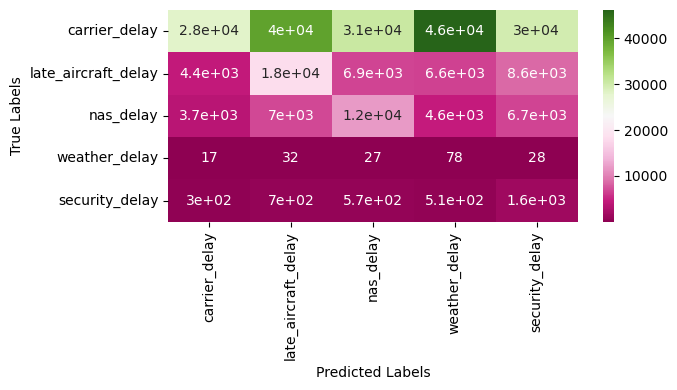

In [96]:
y_pred = clf.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (7,4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'PiYG')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()

plt.show()

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      carrier_delay       0.77      0.16      0.27    174097
late_aircraft_delay       0.28      0.41      0.33     44522
          nas_delay       0.24      0.35      0.28     33842
     security_delay       0.00      0.43      0.00       182
      weather_delay       0.03      0.43      0.06      3642

           accuracy                           0.23    256285
          macro avg       0.26      0.35      0.19    256285
       weighted avg       0.60      0.23      0.28    256285



## Model: Naive Bayes GaussianNB

In [24]:
# scale and train model
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
nbG = GaussianNB()

# Model training
nbG.fit(X_scaled, y_train)


# testing the test data
X_test_scaled = scaler.transform(X_test)
nbG.score(X_test_scaled, y_test)

0.028807772596913594

In [25]:
y_pred = nbG.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

      carrier_delay       1.00      0.00      0.00    174097
late_aircraft_delay       0.25      0.00      0.00     44522
          nas_delay       0.23      0.15      0.18     33842
     security_delay       0.00      0.63      0.00       182
      weather_delay       0.02      0.62      0.04      3642

           accuracy                           0.03    256285
          macro avg       0.30      0.28      0.04    256285
       weighted avg       0.75      0.03      0.02    256285



In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, nbG.predict_proba(X_test_scaled), multi_class = 'ovo')

0.6248401476757677

## Testing on Submission Data

In [74]:
test = pd.read_csv('../datasets/flights_test.csv')
test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,2020-01-01 00:00:00,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,2020-01-01 00:00:00,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,2020-01-01 00:00:00,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,2020-01-01 00:00:00,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,2020-01-01 00:00:00,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


In [75]:
# preprocess the data
X_testing = preparing_test_dataset(test)

# apply scaling
X_testing_scaled = scaler.transform(X_testing)

# load the saved model
# test the data
y_testing = clf.predict(X_testing_scaled)

In [78]:
y_testing

array(['late_aircraft_delay', 'security_delay', 'security_delay', ...,
       'carrier_delay', 'carrier_delay', 'carrier_delay'], dtype=object)

In [82]:
pd.DataFrame(y_testing).to_csv('flights_test_results.csv')